In [416]:
""" Position Adjust:

1. All players should be in the area(300 < X < 910, 300 < Y < 600)
2. Most of the players in around the penalty spot area[650 < X < 820, 300 < Y < 600] (at least 5 players each team)
3. Most of the Players from two teams should be defend the opposing players(at least 7 players)
4. Players cannot overlap (set a tolerance)
5. Cannot move the White Team players to the Blue Team sample player

 """

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torchvision

In [417]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

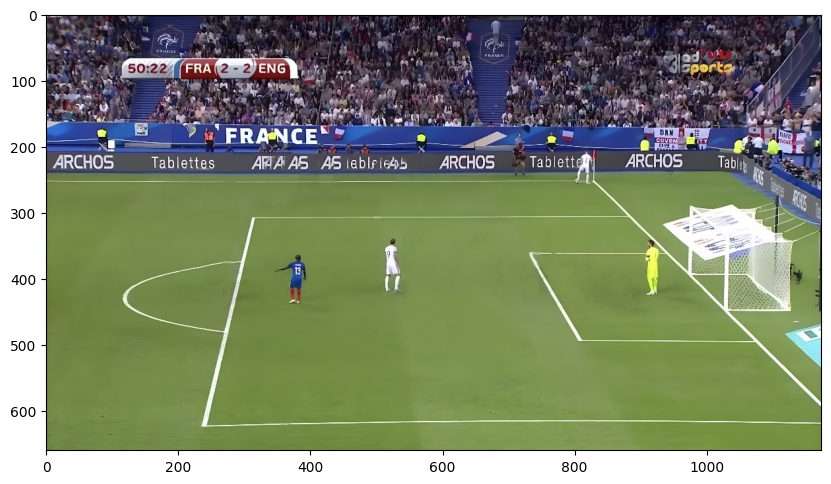

In [418]:
image = cv2.imread('Dataset/Corner-kick/ck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [419]:

from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

d:\yutol\Capstone\T2I-soccer-cornerkick-freekick\T2IEnv\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch

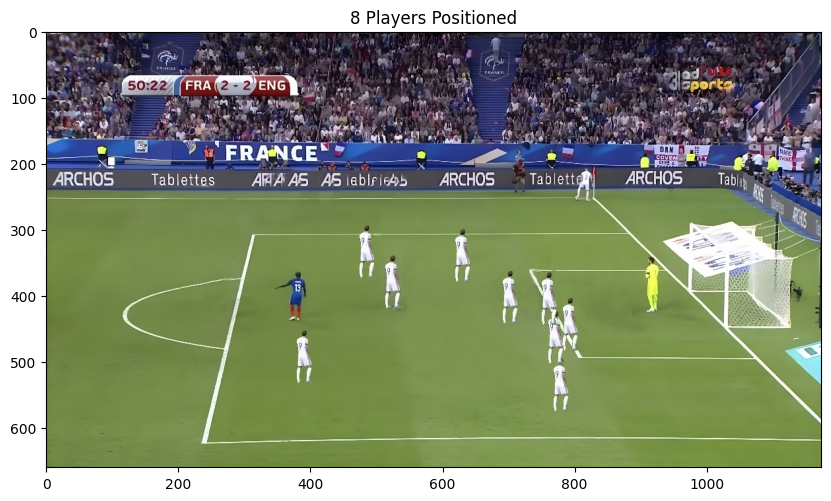

In [426]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

input_point = np.array([[520, 378]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Find the best mask index
best_mask_idx = np.argmax(scores)
best_mask = masks[best_mask_idx]

# Get the coordinate range of the mask
y_indices, x_indices = np.where(best_mask)
if len(x_indices) == 0 or len(y_indices) == 0:
    raise ValueError("Mask area is empty")

min_x, max_x = np.min(x_indices), np.max(x_indices)
min_y, max_y = np.min(y_indices), np.max(y_indices)
image_height, image_width = image.shape[:2]

# Define the field area constraints
x_range = (300, 910)
y_range = (290, 600)

# Define penalty area constraints for most players
penalty_x_range = (650, 820)
penalty_y_range = (300, 600)

num_players = 8
total_players = num_players
result = image.copy()

# Keep track of occupied positions to prevent overlap
occupied_positions = set()

# Function to check if the new position is overlapping
def is_overlapping(new_x, new_y, occupied_positions, tolerance=16):
    for (ox, oy) in occupied_positions:
        if abs(new_x - ox) < tolerance and abs(new_y - oy) < tolerance:
            return True
    return False

# Generate positions for players  
players_move_distance = []
penalty_players = 0  # Count players near the penalty area
white_players_position = []

i = 0
while i < num_players:
    # Ensure most players are around the penalty spot
    while True:
        if penalty_players < 5:   
            dx = np.random.randint(penalty_x_range[0] - min_x, penalty_x_range[1] - max_x)
            dy = np.random.randint(penalty_y_range[0] - min_y, penalty_y_range[1] - max_y)

        else:
            dx = np.random.randint(x_range[0] - min_x, x_range[1] - max_x)
            dy = np.random.randint(y_range[0] - min_y, y_range[1] - max_y)

        if not (-55 <= dy <= 99 and -184 <= dx <= -120): #avoid moving the White Team players to the Blue Team sample player
            break

    # Ensure no overlap
    new_x, new_y = min_x + dx, min_y + dy
    if not is_overlapping(new_x, new_y, occupied_positions):
        occupied_positions.add((new_x, new_y))
        players_move_distance.append((dx, dy))
        penalty_players += 1 if (650 <= new_x <= 820 and 300 <= new_y <= 600) else 0
        i += 1

# Copy and paste players to new positions

for dx, dy in players_move_distance:
    y_indices_new = y_indices + dy
    x_indices_new = x_indices + dx

    valid = (x_indices_new >= 0) & (x_indices_new < image_width) & (y_indices_new >= 0) & (y_indices_new < image_height)
    y_valid, x_valid = y_indices_new[valid], x_indices_new[valid]
    white_players_position.append([y_valid, x_valid])

    # Copy the object to the new position
    result[y_valid, x_valid] = image[y_indices[valid], x_indices[valid]]

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.title(f"{num_players} Players Positioned")
plt.axis('on')
plt.show()

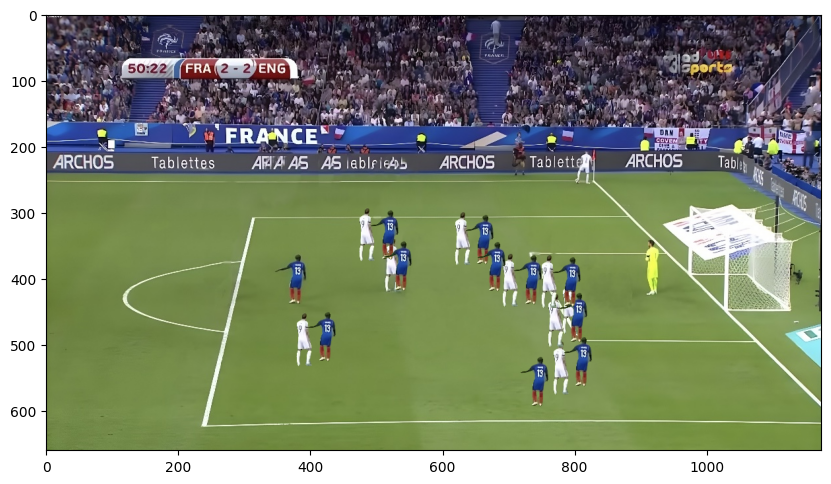

In [427]:
input_point_blue = np.array([[378, 398]])
input_label_blue = np.array([1])

masks, scores, logit = predictor.predict(
    point_coords = input_point_blue,
    point_labels = input_label_blue,
    multimask_output = True,
)

best_mask_idx = np.argmax(scores)
best_mask = masks[best_mask_idx]

final_result = result.copy()
goal_pointer = np.array([999, 415])
y_indices_blue, x_indices_blue = np.where(best_mask)
y_min_blue, y_max_blue = np.min(y_indices_blue), np.max(y_indices_blue)
x_min_blue, x_max_blue = np.min(x_indices_blue), np.max(x_indices_blue)

some_players_blue = 0
blue_players_positions = []

if len(y_indices_blue) == 0 or len(x_indices_blue) == 0:
    raise ValueError("Masks area is empty")

# function to get the x and y distance need to move
def move_along_vector(A, u, distance=18):

    u = np.array(u, dtype=np.float64) 
    norm = np.linalg.norm(u)  
    
    if norm == 0:
        raise ValueError("V can not be 0")
    
    unit_u = u / norm  
    delta_x, delta_y = unit_u * distance  
    
    return delta_y, delta_x

np_array = np.array(white_players_position)


# save part of blue team players who right against white team players move distance
for white_player in white_players_position[num_players-7:]:
    y_indices, x_indices = white_player
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    x_min, x_max = np.min(x_indices), np.max(x_indices)

    v = goal_pointer - (x_min, y_min)      
    y_distance, x_distance = move_along_vector((x_min,y_min), v)
 
    y_new = y_min + y_distance
    x_new = x_min + x_distance
    if not is_overlapping(x_new, y_new, occupied_positions):
        occupied_positions.add((x_new, y_new))          

        y_distance = y_new - y_min_blue
        x_distance = x_new - x_min_blue
        blue_players_positions.append((y_distance, x_distance))
        
        some_players_blue += 1

# save rest of the blue players move distance
blue_players = 9
while some_players_blue < blue_players:
    y_distance = np.random.randint(penalty_y_range[0] - y_min_blue, penalty_y_range[1] - y_max_blue)
    x_distance = np.random.randint(penalty_x_range[0] - x_min_blue, penalty_x_range[1] - x_max_blue)

    y_new = y_min_blue + y_distance
    x_new = x_min_blue + x_distance
    if not is_overlapping(x_new, y_new, occupied_positions):
        occupied_positions.add((x_new, y_new))
        blue_players_positions.append((y_distance, x_distance))

        some_players_blue += 1

# copy and move all the players
blue_players_positions.append((-20, 160)) # add a blue player against the sample white player
for y_distance, x_distance in blue_players_positions:
    y_indices_new = np.round(y_indices_blue + y_distance).astype(int)
    x_indices_new = np.round(x_indices_blue + x_distance).astype(int)

    valid = (x_indices_new >= 0) & (x_indices_new < image_width) & (y_indices_new >= 0) & (y_indices_new < image_height)
    y_valid, x_valid = y_indices_new[valid], x_indices_new[valid]
    
    final_result[y_valid, x_valid] = result[y_indices_blue[valid], x_indices_blue[valid]]

plt.figure(figsize=(10,10))       
plt.imshow(final_result)
plt.axis("on")
plt.show()

In [194]:
ymin = y_min_blue - max_y
ymax = y_max_blue - min_y
xmin = x_min_blue - max_x
xmax = x_max_blue - min_x
print(ymin, ymax)
print(xmin, xmax)


-55 99
-184 -120


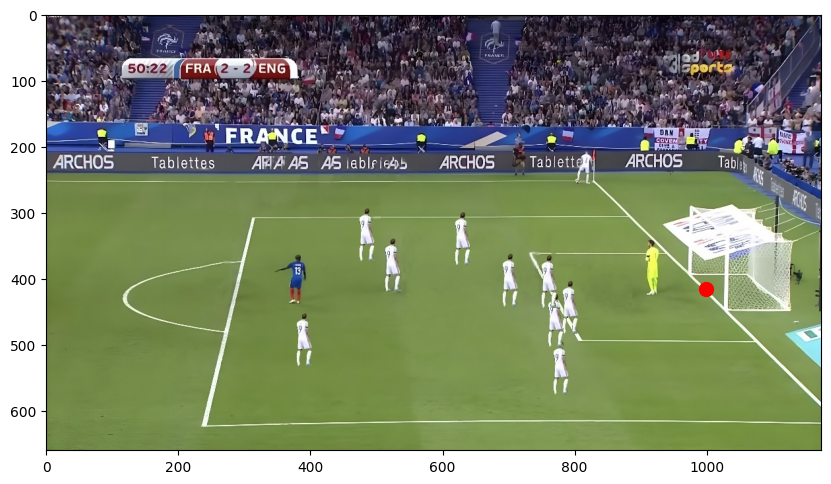

In [428]:
plt.figure(figsize=(10, 10))
plt.imshow(result)
plt.scatter(999, 415, color='red', s=100)
plt.axis('on')
plt.show()